<a href="https://colab.research.google.com/github/sonakshisen1234/NLP_Course/blob/master/bigrams_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
loss:3.7747436636477616
loss:5.222374058005375
loss:3.9765916248061504
loss:3.612598349714371
loss:3.5876537541675435
loss:4.662252387588041
loss:4.167613003199833
loss:4.990584904925572
loss:5.071920735092016
loss:4.292847108699367
loss:3.539292852946298
loss:4.2760911007127635
loss:5.133211983608695
loss:5.43588799161455
loss:4.241784150182835
loss:4.738309835618108
loss:5.3909211900165825
loss:4.946491448588732
loss:4.1937459091255365
loss:4.47173963526763
loss:4.555883162865725
loss:4.06050544171274
loss:3.971144381183702
loss:4.260944517600531
loss:4.564639210457846
loss:3.590013137294893
loss:5.845297678959663
loss:4.85764167219546
loss:4.2290823370974895
loss:4.223491463426208
loss:4.85443781178021
loss:2.288910696640386
loss:5.145721200595995
loss:4.836107950297485
loss:5.116727184319761
loss:5.119239995130514
loss:4.216889577479545
loss:3.017191877635447
loss:4.001302731127927
loss:3.580647654491099
loss:5.5924693667144325
los

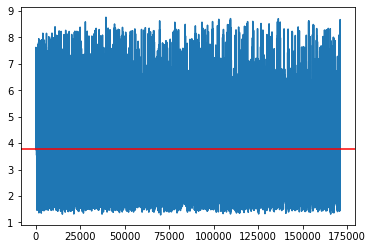

In [0]:
import nltk
from nltk.corpus import brown
import operator
import numpy as np
from future.utils import iteritems
import matplotlib.pyplot as plt
import random

nltk.download('brown')

KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences():
  # returns 57340 of the Brown corpus
  # each sentence is represented as a list of individual string tokens
  return brown.sents()


def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS):
  sentences = get_sentences()
  indexed_sentences = []

  i = 2
  word2idx = {'START': 0, 'END': 1}
  idx2word = ['START', 'END']

  word_idx_count = {
    0: float('inf'),
    1: float('inf'),
  }

  for sentence in sentences:
    indexed_sentence = []
    for token in sentence:
      token = token.lower()
      if token not in word2idx:
        idx2word.append(token)
        word2idx[token] = i
        i += 1

      # keep track of counts for later sorting
      idx = word2idx[token]
      word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

      indexed_sentence.append(idx)
    indexed_sentences.append(indexed_sentence)



  # restrict vocab size

  # set all the words I want to keep to infinity
  # so that they are included when I pick the most
  # common words
  for word in keep_words:
    word_idx_count[word2idx[word]] = float('inf')

  sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
  word2idx_small = {}
  new_idx = 0
  idx_new_idx_map = {}
  for idx, count in sorted_word_idx_count[:n_vocab]:
    word = idx2word[idx]
    #print(word, count)
    word2idx_small[word] = new_idx
    idx_new_idx_map[idx] = new_idx
    new_idx += 1
  # let 'unknown' be the last token
  word2idx_small['UNKNOWN'] = new_idx 
  unknown = new_idx

  assert('START' in word2idx_small)
  assert('END' in word2idx_small)
  for word in keep_words:
    assert(word in word2idx_small)

  # map old idx to new idx
  sentences_small = []
  for sentence in indexed_sentences:
    if len(sentence) > 1:
      new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
      sentences_small.append(new_sentence)

  return sentences_small, word2idx_small

def get_bigram_probs(sentences,V,start_index,end_index,smoothing=1): #function to get bigram probability matrix
  matrix = np.ones((V,V)) * smoothing # create matrix of V*V and intialize with smoothing parameter
  for sentence in sentences:
    for i in range (len(sentence)):
      if(i==0):
        matrix[start_index,sentence[i]]+=1
      else:
        matrix[sentence[i-1],sentence[i]]+=1
      if(i==len(sentence)-1):
        matrix[sentence[i],end_index]+=1
  x = matrix.sum(axis=1,keepdims=True) #sum each row(to attain normalization)(P(B/A) = count(A followed by B)/count(A))
  matrix/=x
  return matrix          


sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)
V = len(word2idx)
start_idx = word2idx['START']
end_idx = word2idx['END']

bigram_probs = get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=0.1)

W = np.random.randn(V,V)/np.sqrt(V) ## shape is V*V

W_bigram = np.log(bigram_probs)
bigram_losses = []
losses = []
epochs = 3
lr = 0.1

def softmax(x):
  x = x - np.max(x)
  e_x = np.exp(x)
  e_x = e_x/e_x.sum(axis=1,keepdims=True)
  return e_x

j=0
for epoch in range(epochs):
  random.shuffle(sentences) ## shuffle sentences in each epoch
  for sentence in sentences:
    sentence = [start_idx] + sentence + [end_idx]
    n = len(sentence)
    inputs = np.zeros((n-1,V)) # n-1(end_idx is excluded)
    targets = np.zeros((n-1,V))
    
    inputs[np.arange(n-1),sentence[:n-1]] = 1 #one hot encoding of inputs
    targets[np.arange(n-1),sentence[1:]] = 1 #one hot encoding of targets(denoting next word)
    predictions = softmax(inputs.dot(W))
    
    W = W - lr*inputs.T.dot(predictions-targets) ### applying gradient descent in logistic regression(theta = theta - alpha*input*(predicted-target))
    loss = -np.sum(targets*np.log(predictions))/(n-1) ### loss function in logisticc regression,division by n-1(number of training examples)
    losses.append(loss)
    if epoch == 0:
        bigram_predictions = softmax(inputs.dot(W_bigram))
        bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1) ## finding loss using normal bigrams where counts are used
        bigram_losses.append(bigram_loss)
    if j % 10 == 0:
        print(  "loss:" + str(loss))
    j+=1   


plt.plot(losses)
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-') ## plotting horizontal line
  
